In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ishita\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [25]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [27]:
!pip install xgboost

In [8]:
data = pd.read_csv('amazon_alexa.tsv', delimiter='\t')

In [9]:
data
print(f"Dataset shape is {data.shape}")

Dataset shape is (3150, 5)


In [10]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [11]:
print(f"Features in the dataset is {data.columns.values}")

Features in the dataset is ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [17]:
#checking for null check
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [13]:
# to find the length of the verified reviews

data['length'] = data['verified_reviews'].apply(len)

In [14]:
data

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5
...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1,50
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1,135
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1,441
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1,380


In [20]:
#verifiing if the length col is working fine - 


In [22]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

ratings, feedback, length are integers <br>
date, variations and verified reviews is obj(s)

In [34]:
#ratings

print(f"The value of rating counts is: \n{data['rating'].value_counts()}")

The value of rating counts is: 
5    2286
4     455
1     161
3     152
2      96
Name: rating, dtype: int64


Now we are creating 2 sentiments here - positive and negative. If i take neutral then the rating 3 has 152 so my result will be highly skewed.

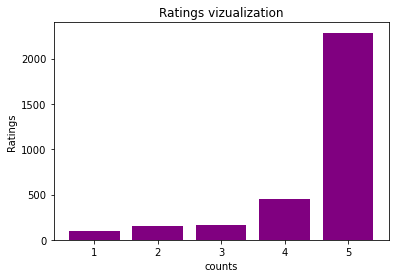

In [52]:
rates = data['rating']

plt.bar(rates.unique(), rates.value_counts(),color='purple')
plt.xlabel('counts')
plt.ylabel('Ratings')
plt.title("Ratings vizualization")
plt.show()

In [67]:
#finding the percentage distribution of each rating

print(f"Value Percentage:\n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Value Percentage:
5    72.57
4    14.44
1     5.11
3     4.83
2     3.05
Name: rating, dtype: float64


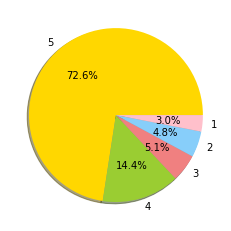

In [79]:
colors = ['gold','yellowgreen','lightcoral','lightskyblue','pink']
labels= rates.unique()
value = data['rating'].value_counts()/data.shape[0]
explode=(0.1,0.1,0.1,0.1,0.1)
plt.pie(value, labels=labels, colors =colors, autopct="%.1f%%", shadow= True)
plt.show()

Analyzing the feedback columns

In [83]:
print(f"Feedback column counts:\n{data['feedback'].value_counts()}")

Feedback column counts:
1    2893
0     257
Name: feedback, dtype: int64


now there are 2 types of feebacks either 1 or 0, now we need to find out what these 2 actually correspond to

In [101]:
review_0 = data[data['feedback']==0].iloc[1]['verified_reviews']
review_0

'Sound is terrible if u want good music too get a bose'

In [104]:
review_1 = data[data['feedback']==1].iloc[154]['verified_reviews']
review_1

'This is great item and just added audible books which makes it even better. Thank you!'

From the above 2 examples we can see that the feedbacl 1 means "Positive Review" with ratings [4,5,3] and 0 means "Negative Review" with ratings [0,1]

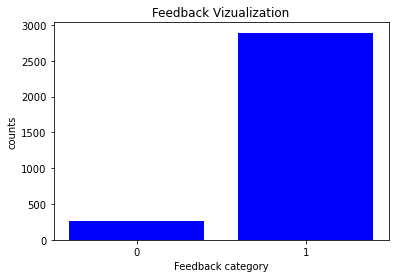

In [134]:
#Plotting for feedback
feedback = data['feedback'].value_counts()

plt.bar(feedback.index, feedback.values, color = "blue")
plt.xlabel('Feedback category')
plt.ylabel('counts')
plt.xticks([0, 1])
plt.title("Feedback Vizualization")
plt.show()



In [137]:
# % distribution of the feebacks

round(data['feedback'].value_counts()/data.shape[0]*100,2)

1    91.84
0     8.16
Name: feedback, dtype: float64

So  91.84% reviews are positive and rest 8.16% is negative

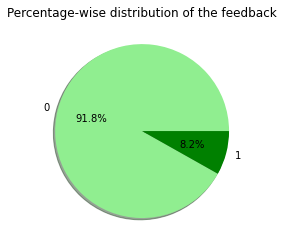

In [141]:
colors = ['lightgreen','green']
value = data['feedback'].value_counts()/data.shape[0]
explode=(0.1,0.1)
plt.pie(value, labels=labels, colors =colors, autopct="%.1f%%", shadow= True)
plt.title("Percentage-wise distribution of the feedback")
plt.show()

In [145]:
#let's find the ratings associated with the feedbacks
data[data['feedback']==0]['rating'].value_counts()

1    161
2     96
Name: rating, dtype: int64

In [146]:
data[data['feedback']==1]['rating'].value_counts()

5    2286
4     455
3     152
Name: rating, dtype: int64

So those data with positive feedbacks have ratings either 3,4 or 5 and the ones with negative feedback have ratings 1 and 2

Analyzing variations coulumns

In [148]:
print(f"Variations column:\n{data['variation'].value_counts()}")

Variations column:
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: variation, dtype: int64


These are the different variations of Alexa available on Amazon

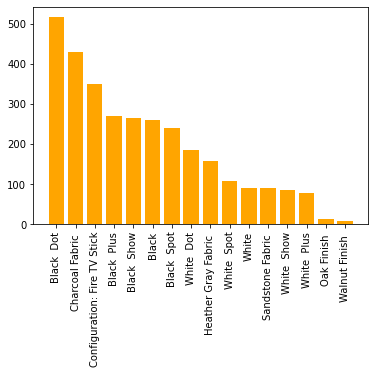

In [156]:
variations = data['variation'].value_counts()
plt.bar(variations.index, variations.values, color="orange")
plt.xticks(rotation=90)
plt.show()

In [167]:
print(f"Percentage of different Alexa variation is: \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")

Percentage of different Alexa variation is: 
Black  Dot                      16.38
Charcoal Fabric                 13.65
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.41
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.98
White  Spot                      3.46
White                            2.89
Sandstone Fabric                 2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: variation, dtype: float64


Finding the mean ratings for different variations

In [175]:
data.groupby('variation')['rating'].mean().sort_values()

variation
White                           4.142857
Black                           4.233716
White  Show                     4.282353
Black  Spot                     4.311203
White  Spot                     4.311927
Sandstone Fabric                4.355556
White  Plus                     4.358974
Black  Plus                     4.370370
White  Dot                      4.423913
Black  Dot                      4.453488
Black  Show                     4.490566
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Charcoal Fabric                 4.730233
Oak Finish                      4.857143
Walnut Finish                   4.888889
Name: rating, dtype: float64

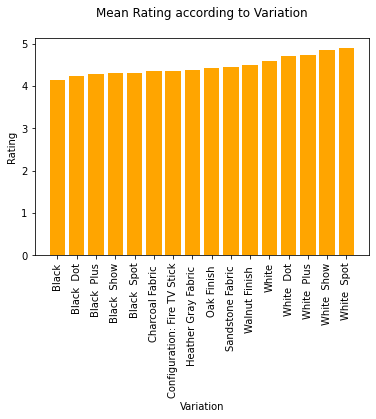

In [10]:

mean = data.groupby('variation')['rating'].mean()
plt.bar(mean.index, mean.sort_values(), color="orange")
plt.xticks(rotation =90)
plt.title("Mean Rating according to Variation\n")
plt.xlabel("Variation")
plt.ylabel("Rating")
plt.show()

From the above people who have taken White Spot variation of Alexa tend to give better ratings almost near to 5, while least rating is of the Black variation, with mean rating just above 4

In [4]:
corr= data.corr()
corr

,rating,feedback
rating,1.000000,0.861968
feedback,0.861968,1.000000


<AxesSubplot:>

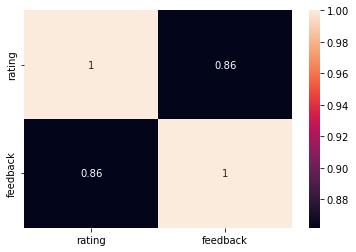

In [6]:
sns.heatmap(corr, annot =True)

Analyzing Verified columns

This contains the textual review given by a user for different variations

In [15]:
data['length'].describe()

count    3150.000000
mean      132.049524
std       182.099952
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of reviews if feedback is 0\n')]

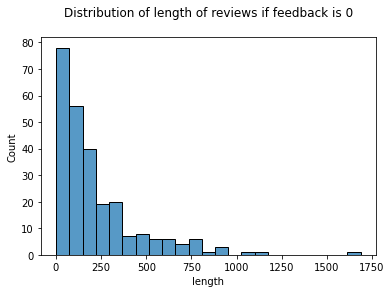

In [24]:
#length when the ratings are negative that is 0

sns.histplot(data[data['feedback']==0]['length']).set(title="Distribution of length of reviews if feedback is 0\n")

[Text(0.5, 1.0, 'Distribution of length of reviews if feedback is 1')]

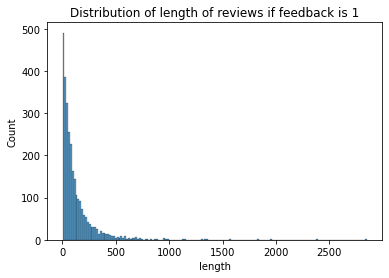

In [27]:
sns.histplot(data[data['feedback']==1]['length']).set(title="Distribution of length of reviews if feedback is 1")

Text(0, 0.5, 'length')

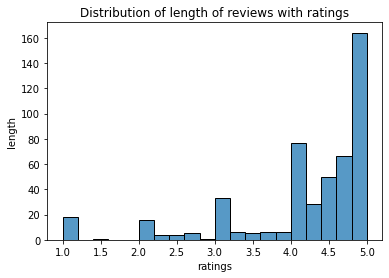

In [38]:
#length and rating

sns.histplot(data.groupby('length')['rating'].mean(), bins=20).set(title="Distribution of length of reviews with ratings")
plt.xlabel('ratings')
plt.ylabel('length')

From above we see that most of the high rated reviews are mostly lengthy, than the ones which have lower ratings  have shorter length less than 25 words

In [40]:
cv = CountVectorizer(stop_words="english")
words = cv.fit_transform(data.verified_reviews)
#fit_transform fits and transforms the text data

In [57]:
pip install --upgrade wordcloud pillow

  Attempting uninstall: pillow
    Found existing installation: Pillow 9.0.1
    Uninstalling Pillow-9.0.1:
      Successfully uninstalled Pillow-9.0.1



stop words are common words in a language that are usually ignored in text processing because they don’t carry much meaning. Examples in English include:

Articles: a, an, the
Prepositions: in, on, at, by
Pronouns: he, she, they, it
Conjunctions: and, or, but, because
Common Verbs: is, am, are, was, were, has, have
<br>
Why Remove Stop Words?
When analyzing text, these words appear frequently but don’t contribute much to understanding the content. Removing them makes the dataset smaller and more relevant for machine learning models.

you can also remove custom words like 
vectorizer = CountVectorizer(stop_words=['data', 'science']) 

In [71]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
import matplotlib.font_manager as fm

# wc = WordCloud(font_path= r'C:\Users\Ishita\Downloads\Weather-App-with-Python-Django\Weather App with Python Django\staticfiles\fonts\fontawesome-webfont.ttf',background_color='white', max_words=50)
# wc_image = wc.generate(reviews)



# # Generate and plot wordcloud
# plt.figure(figsize=(10,10))
# plt.imshow(wc_image, interpolation = 'bilinear')
# plt.title('Wordcloud for all reviews', fontsize=10)
# plt.axis('off')
# plt.show()
print(f'{reviews}\n')

Love my Echo! Loved it! Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home. I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well. Music I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do. Without having a cellphone, I cannot use many of her features. I have an iPad but do not see that of any use.  It IS a great alarm.  If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response.  She does not seem to be very smartbon politics yet. I think this is the 5th one I've purchased. I'm working on get

In [53]:
import os
font_dir = "C:/Windows/Fonts/verdanab.ttf"
fonts = [f for f in os.listdir(font_dir) if f.endswith(".ttf")]
print(fonts)

['arial.ttf', 'arialbd.ttf', 'arialbi.ttf', 'ariali.ttf', 'ariblk.ttf', 'bahnschrift.ttf', 'calibri.ttf', 'calibrib.ttf', 'calibrii.ttf', 'calibril.ttf', 'calibrili.ttf', 'calibriz.ttf', 'cambriab.ttf', 'cambriai.ttf', 'cambriaz.ttf', 'Candara.ttf', 'Candarab.ttf', 'Candarai.ttf', 'Candaral.ttf', 'Candarali.ttf', 'Candaraz.ttf', 'comic.ttf', 'comicbd.ttf', 'comici.ttf', 'comicz.ttf', 'consola.ttf', 'consolab.ttf', 'consolai.ttf', 'consolaz.ttf', 'constan.ttf', 'constanb.ttf', 'constani.ttf', 'constanz.ttf', 'Cookie-Regular.ttf', 'corbel.ttf', 'corbelb.ttf', 'corbeli.ttf', 'corbell.ttf', 'corbelli.ttf', 'corbelz.ttf', 'cour.ttf', 'courbd.ttf', 'courbi.ttf', 'couri.ttf', 'ebrima.ttf', 'ebrimabd.ttf', 'EncodeSansCompressed-100-Thin.ttf', 'EncodeSansCompressed-200-ExtraLight.ttf', 'EncodeSansCompressed-300-Light.ttf', 'EncodeSansCompressed-400-Regular.ttf', 'EncodeSansCompressed-500-Medium.ttf', 'EncodeSansCompressed-600-SemiBold.ttf', 'EncodeSansCompressed-700-Bold.ttf', 'EncodeSansCompre

In [72]:
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

# unique_positive = [x for x in pos_reviews if x not in neg_reviews]
# unique_positive = " ".join(unique_positive)
# wc = WordCloud(background_color='white', max_words=50)

# # Generate and plot wordcloud
# plt.figure(figsize=(10,10))
# plt.imshow(wc.generate(unique_negative))
# plt.title('Wordcloud for negative reviews', fontsize=10)
# plt.axis('off')
# plt.show()

print(neg_reviews)

["it's", 'like', 'siri,', 'in', 'fact,', 'siri', 'answers', 'more', 'accurately', 'then', 'alexa.', 'i', "don't", 'see', 'a', 'real', 'need', 'for', 'it', 'in', 'my', 'household,', 'though', 'it', 'was', 'a', 'good', 'bargain', 'on', 'prime', 'day', 'deals.', 'sound', 'is', 'terrible', 'if', 'u', 'want', 'good', 'music', 'too', 'get', 'a', 'bose', 'not', 'much', 'features.', 'stopped', 'working', 'after', '2', 'weeks', ",didn't", 'follow', 'commands!?', 'really', 'fun', 'when', 'it', 'was', 'working?', 'sad', 'joke.', 'worthless.', 'really', 'disappointed', 'alexa', 'has', 'to', 'be', 'plug-in', 'to', 'wall', 'socket', 'all', 'the', 'time.', 'my', 'fault', 'for', 'not', 'checking', 'this,', 'but', 'made', 'the', 'assumption', 'that', 'a', 'company', 'has', 'technologically', 'advanced', 'as', 'amazon', 'would', 'sell', 'this', 'product', 'with', 'a', 'rechargeable', 'battery.', 'if', 'i', 'could', 'return', 'it,', 'i', 'would', 'as', 'my', 'apple', 'music', 'and', 'boom', 'speaker', 'g

#### Processing and Modelling

To build the corpus from the 'verified_reviews' we perform the following -

1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [11]:
corpus =[] #This will store the cleaned and stemmed text for each review.
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):  #loop through all the reviews in all the rows
    review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews']) #Removes all non-alphabetic characters (numbers, symbols, punctuation).✅ Replaces them with a space.
    review = review.lower().split() #lowercase and then split them into individual words in an array
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    '''
    Stopwords are common words (like "the", "is", "in", "and") that don’t add much meaning to the text.
    ✅ Example: "I am loving this amazing product"
    ✅ After stopword removal: ["loving", "amazing", "product"]

    Stemming reduces words to their root form:
    ✅ "loving" → "love"
    ✅ "studies" → "studi"
    ✅ "running" → "run"
    '''
    review = ' '.join(review) #Joins the cleaned words back into a sentence.
    corpus.append(review)

what is [^a-zA-Z]
<br>
The pattern [^a-zA-Z] is a regular expression (regex) that matches any character that is not an English letter.

Breaking It Down:
Square Brackets [ ]:
They define a character set, meaning the regex will look for any character inside the brackets.

a-z and A-Z:

a-z covers all lowercase letters (a, b, c, ..., z).
A-Z covers all uppercase letters (A, B, C, ..., Z).
Caret ^ Inside Brackets:
When placed as the first character inside the brackets, it negates the character set. This means "match anything that is not in this set."

In Context:
When you use re.sub('[^a-zA-Z]', ' ', text), it means:
Replace any character that is not a letter (a-z or A-Z) with a space.
This is a common technique in text processing to clean text by removing punctuation, numbers, and other symbols, leaving only alphabetic characters.

In [12]:
# Using Count Vectorizer to create bag of words

cv = CountVectorizer(max_features = 2500)
x = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [13]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: 'Models/countVectorizer.pkl'

In [14]:
# Checking shape of x and y
print(f"X shape: {x.shape}")
print(f"y shape: {y.shape}")

X shape: (3150, 2500)
y shape: (3150,)


Splitting the data in 30% data with testing

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2205, 2500)
y train: (2205,)
X test: (945, 2500)
y test: (945,)


In [17]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")


X train max value: 12
X test max value: 10


We'll scale X_train and X_test so that all values are between 0 and 1.

In [18]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

#### Random Forest

In [19]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [20]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9941043083900227
Testing Accuracy : 0.9365079365079365


In [21]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)


In [22]:
#Confusion Matrix

cm= confusion_matrix(y_test, y_preds)

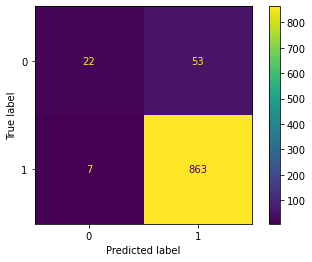

In [23]:
cm_display = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= model_rf.classes_)
cm_display.plot()

Understanding the confusion matrix:

- The model correctly predicted 22 negative reviews as negative. ✅
- The model wrongly classified 53 negative reviews as positive (false alarm). ❌
- The model missed 7 positive reviews and classified them as negative. ❌
- The model correctly predicted 863 positive reviews as positive. ✅

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_preds)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_preds)
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(y_test, y_preds)
print("Recall (Sensitivity):", recall)

Accuracy: 0.9365079365079365
Precision: 0.9421397379912664
Recall (Sensitivity): 0.9919540229885058


K-cross fold validation

In [25]:
accuracies = cross_val_score(estimator = model_rf, X= X_train_scl, y = y_train, cv=10)

print('Accuracy: ', accuracies.mean())
print("Standard Variation" , accuracies.std())

Accuracy:  0.9342513368983957
Standard Variation 0.010104633871626273


So what does the above numbers mean

> An <b>accuracy</b> of 93.6% shows that on an avg RF model correctlt predicts the model 93.6% of the time. K fold took this accuracy as the avg of accuracy accross K different folds
<br><br>
> <b>Standard deviation</b> tells you how much the accuracy varies across different folds.
A low standard deviation (1.12%) means your model is performing consistently well across different data splits.
If the standard deviation was high (e.g., >5%), it would suggest that your model performs well on some splits but poorly on others, indicating potential overfitting or data imbalance.

In [26]:
#Applying grid search to get the optimal parameters on random forest



### XGBoost

In [27]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [28]:
#Accuracy of the model on the training and testing data

print("Training Accuracy:", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy:", model_xgb.score(X_test_scl, y_test))

Training Accuracy: 0.9700680272108844
Testing Accuracy: 0.9407407407407408


In [29]:
y_pred = model_xgb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

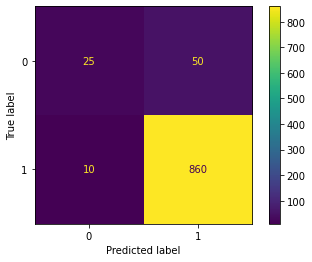

In [33]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

Understanding the confusion matrix:
<BR>
- The model correctly predicted 25 negative reviews as negative. ✅
- The model wrongly classified 50 negative reviews as positive (false alarm). ❌
- The model missed 10 positive reviews and classified them as negative. ❌
- The model correctly predicted 860 positive reviews as positive. ✅


In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(y_test, y_pred)
print("Recall (Sensitivity):", recall)

Accuracy: 0.9365079365079365
Precision: 0.945054945054945
Recall (Sensitivity): 0.9885057471264368


In [40]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: 'Models/model_xgb.pkl'

### Decision Tree Classifier

In [43]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [44]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9941043083900227
Testing Accuracy : 0.9153439153439153


In [45]:
y_preds = model_dt.predict(X_test)

In [46]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 34  41]
 [ 70 800]]


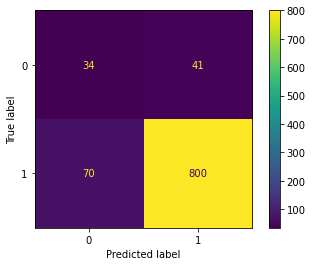

In [47]:

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

Understanding the confusion matrix:

- The model correctly predicted 34 negative reviews as negative. ✅
- The model wrongly classified 41 negative reviews as positive (false alarm). ❌
- The model missed 70 positive reviews and classified them as negative. ❌
- The model correctly predicted 800 positive reviews as positive. ✅

In [48]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_preds)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_preds)
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(y_test, y_preds)
print("Recall (Sensitivity):", recall)

Accuracy: 0.8825396825396825
Precision: 0.9512485136741974
Recall (Sensitivity): 0.9195402298850575
